In [ ]:
%tensorflow_version 2.x   #TensorFlow is a Python library for fast numerical
                          #computing created and released by Google.

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from imutils import paths  #A series of convenience functions to make basic
                           #image processing functions such as translation, rotation, resizing,
                           #skeletonization, displaying Matplotlib images*/

from tqdm import tqdm      #used for creating Progress Meters or Progress Bars
import numpy as np
from glob import glob      #used to return all file paths that match a specific pattern
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf    #converts regular python code to a callable Tensorflow graph function
import datetime
import IPython.display as display
from IPython.display import clear_output
from google.colab import files
import math
import time
tf.__version__
!sudo pip3 install keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')   #it ignores warning messages
AUTOTUNE = tf.data.experimental.AUTOTUNE   #to find a good allocation of its CPU budget across all parameters
print(f'Tensorflow ver. {tf.__version__}')  #prints version of our tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Tensorflow ver. 2.9.2


In [ ]:
SEED = 42
dataset_path = '/content/drive/MyDrive/segmentation_kaggle_dataset_ceci_project_1/new_idd_dataset_kaggle/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

# Data Visualization
# Sample Training Image
# Plotting The Image

TypeError: ignored

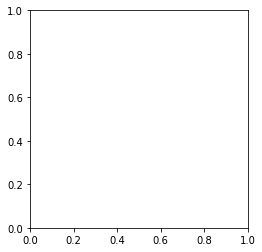

In [ ]:
img = cv2.imread(img_train + "0/024541_image.jpg" , 1)
plt.imshow(img)


In [ ]:
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
img = cv2.imread(seg_train + "0/024541_inst_label.png" , 1)
plt.imshow(img)

In [ ]:
plt.hist(img.ravel(),256,[0,256])
plt.show()

AttributeError: ignored

We can see that all the pixel intensity values lie in the range 0–6.

To get a more clear picture of the values belonging to each class label, let’s count the values belonging to each class.

In [ ]:
plt.hist(img.ravel(),7,[0,7])
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())   # flatten() is used to produce a produces a lateral view
i = np.nonzero(y)[0]
np.vstack((i, y[i])).T

We can observe that the class label 5 has the highest count of values and class 1 has the lowest count.
We can just consider the value 255 as class label 7 as it will be easier for prediction.

# Plotting The Annotated image after intensifying the pixels

In [ ]:
def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                # max value will be 6*40=240 which is under 255
                img_seg[i][j] *= 40
    return img_seg

In [ ]:

# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train + "0/024541_inst_label.png" )

In [ ]:

# Plotting the processed segmentation image
plt.imshow(img_seg)

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,256])
plt.show()

Now, we can easily distinguish the objects after intensifying the pixels as there are colors vary on a wider range, so it is easy to visualize the annotated image.

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8

In [ ]:
# The glob module finds all the pathnames matching a specified pattern according to
# the rules used by the Unix shell, although results are returned in arbitrary order.

TRAINSET_SIZE = len(glob(img_train+'*/*_image.jpg'))
print(f"The Training Dataset contains {TRAINSET_SIZE} images.")

VALSET_SIZE = len(glob(img_val+'*/*_image.jpg'))
print(f"The Validation Dataset contains {VALSET_SIZE} images.")

In [ ]:
def parse_image(img_path):                     #Load an image and its annotation(mask) and returning a dictionary.
    image = tf.io.read_file(img_path)          #reading a image
    image = tf.image.decode_jpeg(image, channels=3)
    # Our one Image path:
    # /idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path:
    # /idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    mask = tf.io.read_file(mask_path)       # Reading the annotation file corresponding the image file
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [ ]:
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [ ]:
def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    tf.random.uniform(()) refers to weater the given image is annoted image or normal image, if its greater than 0.5 then its annoted image
    """
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return tf.convert_to_tensor(input_image), tf.convert_to_tensor(input_mask)

In [ ]:
def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (128,128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128))
    input_image, input_mask = normalize(input_image, input_mask)
    return tf.convert_to_tensor(input_image), tf.convert_to_tensor(input_mask)


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1500
dataset = {"train": train_dataset, "val": val_dataset}

In [ ]:
# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

# Visualizing after processing the data

In [ ]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.

  SHOWS INPUT IMAGE, TRUE MASK, PREDICTED IMAGE - these are in form of list sent in predict function.

    The given display list is in form of array
    3rd line in for loop converts the array into image
    plt.axis is used to show grid
    """

    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
# Getting a sample image for visualizing
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

In [ ]:
# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[0], sample_mask[0]])

In [ ]:
import tensorflow as tf

# Model Building
## U-net ArchitectureModel Building
## U-net Architecture

In [ ]:
# This class is for building the Encoder Block
# Each encoder block (except the first block) consists of 3 layers ->
# Max_Pooling -> Convolution_1 -> Convolution_2
class EncoderBlock(tf.keras.Model):

    def __init__(self, filter_size, block_number, initializer='he_normal'):
        super(EncoderBlock, self).__init__()
        # this variable gives the information about the number of the encoder block
        # this is useful as the first encoder block has a different structure with no max pool layer
        self.block_number = block_number
        # Each encoder block will have different number of filters
        self.filter_size = filter_size
        # defining the max pool layer with size 2
        self.max_pool_layer = MaxPooling2D(pool_size=(2,2))
        # defining the convolution layers
        self.convolution_layer_1 = Conv2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_2 = Conv2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)

    def call(self,inputs):
        # as the first block doesn't have max pool layer we have to define its structure only if the block number is 1
        if(self.block_number==1):
            # the inputs will be passed to the first convolution layer
            x = self.convolution_layer_1(inputs)
            # The output of first convolution layer will be passed to second convolution layer
            x = self.convolution_layer_2(x)
            return x
        # After the first block, for all the encoder blocks the output will be passed to a max_pool layer first
        x = self.max_pool_layer(inputs)
        # The Max pool out will be passed to first convolution layer
        x = self.convolution_layer_1(x)
        # The output of first convolution layer will be passed to the second convolution layer
        x = self.convolution_layer_2(x)
        return x

In [ ]:
#pip install keras


In [ ]:

# This class is for building the Decoder Block
# Each encoder block (except the last block) consists of 4 layers ->
# UpSampling -> Convolution_1 -> Concatenate -> Convolution_2 -> Convolution_3
class DecoderBlock(tf.keras.Model):

    def __init__(self, filter_size, block_number, initializer='he_normal'):
        super(DecoderBlock, self).__init__()
        # Each decoder block has different number of filters
        self.filter_size = filter_size
        # this variable gives the information about the number of the decoder block
        # this is useful as the layer decoder block has a different structure with an extra convolution layer
        self.block_number = block_number
        # defining the UpSampling layer
        self.upsampling_layer = UpSampling2D(size=(2,2))
        # defining the convolution layers
        self.convolution_layer_1 = Conv2D(self.filter_size, 2, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_2 = Conv2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        self.convolution_layer_3 = Conv2D(self.filter_size, 3, activation = 'relu', padding='same', kernel_initializer=initializer)
        # defining the convolution layer for last decoder block
        self.convolution_layer_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)

    def call(self,inputs,encoder_layer):
        # The input is first passed to the UpSampling layer and then passed to the convolution layer
        x = self.convolution_layer_1(self.upsampling_layer(inputs))
        # The output of the convolution layer is concatenated with corresponding encoder layer output
        merged = tf.concat([encoder_layer,x], axis=3)
        # The merged output is passed to second convolution layer
        x = self.convolution_layer_2(merged)
        # The output of the second convolution layer is passed to the third convolution layer
        x = self.convolution_layer_3(x)
        # For the last decoder block, one more convolution layer is added with filter_size = 2
        if(self.block_number==4):
            x = self.convolution_layer_4(x)
        return x

In [ ]:
# This class defines the entire Segmentation Model
# There are 5 Encoder Blocks and 4 Decoder blocks with convolution layer as the last layer
# Encoder_64 -> Encoder_128 -> Encoder_256 -> Encoder_512 -> Encoder_1024 ->
# Decoder_512 -> Decoder_256 -> Deocoder_128 -> Decoder_64 ->
# Convolution_layer (with filter size as number_of_output_channels)
class SegmentationModel(tf.keras.Model):

    def __init__(self, output_channels, initializer = 'he_normal', dynamic=True):
        super(SegmentationModel, self).__init__()
        # getting the number of output channels
        self.output_channels = output_channels
        # defining the encoder blocks with filter sizes 64,128,256,512,1024
        self.encoder_block_1 = EncoderBlock(64,1)
        self.encoder_block_2 = EncoderBlock(128,2)
        self.encoder_block_3 = EncoderBlock(256,3)
        self.encoder_block_4 = EncoderBlock(512,4)
        self.encoder_block_5 = EncoderBlock(1024,5)
        # defining the decoder blocks with filter sizes 512,256,128,64
        self.decoder_block_1 = DecoderBlock(512,1)
        self.decoder_block_2 = DecoderBlock(256,2)
        self.decoder_block_3 = DecoderBlock(128,3)
        self.decoder_block_4 = DecoderBlock(64,4)
        # defining the last convolution layer with filter_size as number_of_output_channels
        self.output_layer = Conv2D(self.output_channels, 1, activation='softmax')

    def call(self,inputs):
        # The input is passed to the first encoder block
        conv_enc_1 = self.encoder_block_1(inputs)
        # Output of each encoder block is passed to the next encoder block
        conv_enc_2 = self.encoder_block_2(conv_enc_1)
        conv_enc_3 = self.encoder_block_3(conv_enc_2)
        conv_enc_4 = self.encoder_block_4(conv_enc_3)
        conv_enc_5 = self.encoder_block_5(conv_enc_4)
        # Output of the previous layer along with the outputs of encoder blocks
        # in reverse orders are passed to decoder layers
        conv_dec_1 = self.decoder_block_1(conv_enc_5,conv_enc_4)
        conv_dec_2 = self.decoder_block_2(conv_dec_1,conv_enc_3)
        conv_dec_3 = self.decoder_block_3(conv_dec_2,conv_enc_2)
        conv_dec_4 = self.decoder_block_4(conv_dec_3,conv_enc_1)
        # Output of the last Decoder layer is passed to the Convolution layer
        output = self.output_layer(conv_dec_4)
        return output

In [ ]:
# Image size that we are going to use
(HEIGHT,WIDTH) = (128,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 8
#from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from keras.layers import UpSampling2D

In [ ]:
# SegmentationModel object
model = SegmentationModel(N_CLASSES)

In [ ]:
# Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

In [ ]:
# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [ ]:
@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)

def train_and_checkpoint(model, manager, dataset, epoch):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/32)):
        tf.convert_to_tensor(x_train)
        tf.convert_to_tensor(y_train)
        train_step(model, optimizer, x_train, y_train)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))

@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

In [ ]:
# Summary writers for Tensorboard visualization
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
# This variable will help to save the best model if its performance increases after an epoch
highest_accuracy = 0

for epoch in range(150):

    print("Epoch ",epoch+1)

    # Getting the current time before starting the training
    # This will help to keep track of how much time an epoch took
    start = time.time()

    train_and_checkpoint(model, manager, dataset, epoch+1)                              #error line

    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())

    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(204/32)):
      a = 0
      pred = test_step(model, x_test, y_test)                                            #error line

    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())

    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)

    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))

    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('unet_weights-epoch-{}.hdf5'.format(epoch+1))

    print('_'*80)

    # Reset metrics after every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

In [ ]:
%load_ext tensorboard


In [ ]:

%tensorboard --logdir logs/

In [ ]:
# Loading the weights of the best model
model.load_weights('/content/drive/MyDrive/Check Points/tf_ckpts/unet_weights-epoch-49.hdf5')


In [ ]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

In [ ]:
# Calling the predict function
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/segmentation_kaggle_dataset_ceci_project_1/new_idd_dataset_kaggle/idd20k_lite/leftImg8bit/val/17/425212_image.jpg')

In [ ]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 8
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
IoU(true_mask, pred_mask)